# Importing RDKit and molvs

In [1]:
import os
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')

try:
    import rdkit
    from rdkit import Chem
    from rdkit.Chem import Draw
    from rdkit import DataStructs
    from rdkit.Chem import AllChem
    from rdkit.Chem import rdmolfiles
    from rdkit.Chem.Draw import IPythonConsole
    IPythonConsole.ipython_useSVG=True
except ImportError:
    print('Stopping RUNTIME. Colaboratory will restart automatically. Please run again.')
    exit()

In [2]:
from molvs import standardize_smiles

# Importing necessary packages

In [3]:
import os
import gc
import sys
import time
import json
import math
import random
import argparse
import itertools
import numpy as np
import mxnet as mx
import pandas as pd
import networkx as nx
from scipy import sparse
from mxnet.gluon import nn
from collections import Counter
from mxnet.autograd import Function
from mxnet.gluon.data import Dataset
from mxnet import gluon, autograd, nd
from mxnet.gluon.data import DataLoader
from abc import ABCMeta, abstractmethod
from mxnet.gluon.data.sampler import Sampler

# Obtaining all molecular properties

In [4]:
class MoleculeSpec(object):

    def __init__(self, file_name='/home/iit/DGGNP/data/atom_types.txt'):
        self.atom_types = []
        self.atom_symbols = []
        with open(file_name) as f:
            for line in f:
                atom_type_i = line.strip('\n').split(',')
                self.atom_types.append((atom_type_i[0], int(atom_type_i[1]), int(atom_type_i[2])))
                if atom_type_i[0] not in self.atom_symbols:
                    self.atom_symbols.append(atom_type_i[0])
        self.bond_orders = [Chem.BondType.AROMATIC,
                            Chem.BondType.SINGLE,
                            Chem.BondType.DOUBLE,
                            Chem.BondType.TRIPLE]
        self.max_iter = 120

    def get_atom_type(self, atom):
        atom_symbol = atom.GetSymbol()
        atom_charge = atom.GetFormalCharge()
        atom_hs = atom.GetNumExplicitHs()
        return self.atom_types.index((atom_symbol, atom_charge, atom_hs))

    def get_bond_type(self, bond):
        return self.bond_orders.index(bond.GetBondType())

    def index_to_atom(self, idx):
        atom_symbol, atom_charge, atom_hs = self.atom_types[idx]
        a = Chem.Atom(atom_symbol)
        a.SetFormalCharge(atom_charge)
        a.SetNumExplicitHs(atom_hs)
        return a

    def index_to_bond(self, mol, begin_id, end_id, idx):
        mol.AddBond(begin_id, end_id, self.bond_orders[idx])

    @property
    def num_atom_types(self):
        return len(self.atom_types)

    @property
    def num_bond_types(self):
        return len(self.bond_orders)

_mol_spec = None

def get_mol_spec():
    global _mol_spec
    if _mol_spec is None:
        _mol_spec = MoleculeSpec()
    return _mol_spec

# Defining utility functions for data preprocessing and postprocessing

In [5]:
def get_graph_from_smiles(smiles):
    mol = Chem.MolFromSmiles(smiles)

    # build graph
    atom_types, atom_ranks, bonds, bond_types = [], [], [], []
    for a, r in zip(mol.GetAtoms(), Chem.CanonicalRankAtoms(mol)):
        atom_types.append(get_mol_spec().get_atom_type(a))
        atom_ranks.append(r)
    for b in mol.GetBonds():
        idx_1, idx_2, bt = b.GetBeginAtomIdx(), b.GetEndAtomIdx(), get_mol_spec().get_bond_type(b)
        bonds.append([idx_1, idx_2])
        bond_types.append(bt)

    # build nx graph
    graph = nx.Graph()
    graph.add_nodes_from(range(len(atom_types)))
    graph.add_edges_from(bonds)

    return graph, atom_types, atom_ranks, bonds, bond_types


def get_graph_from_smiles_list(smiles_list):
    graph_list = []
    for smiles in smiles_list:
        mol = Chem.MolFromSmiles(smiles)

        # build graph
        atom_types, bonds, bond_types = [], [], []
        for a in mol.GetAtoms():
            atom_types.append(get_mol_spec().get_atom_type(a))
        for b in mol.GetBonds():
            idx_1, idx_2, bt = b.GetBeginAtomIdx(), b.GetEndAtomIdx(), get_mol_spec().get_bond_type(b)
            bonds.append([idx_1, idx_2])
            bond_types.append(bt)

        X_0 = np.array(atom_types, dtype=np.int64)
        A_0 = np.concatenate([np.array(bonds, dtype=np.int64),
                              np.array(bond_types, dtype=np.int64)[:, np.newaxis]],
                             axis=1)
        graph_list.append([X_0, A_0])
    return graph_list


def traverse_graph(graph, atom_ranks, current_node=None, step_ids=None, p=0.9, log_p=0.0):
    if current_node is None:
        next_nodes = range(len(atom_ranks))
        step_ids = [-1, ] * len(next_nodes)
        next_node_ranks = atom_ranks
    else:
        next_nodes = graph.neighbors(current_node)  # get neighbor nodes
        next_nodes = [n for n in next_nodes if step_ids[n] < 0] # filter visited nodes
        next_node_ranks = [atom_ranks[n] for n in next_nodes] # get ranks for neighbors
    next_nodes = [n for n, r in sorted(zip(next_nodes, next_node_ranks), key=lambda _x:_x[1])] # sort by rank

    # iterate through neighbors
    while len(next_nodes) > 0:
        if len(next_nodes)==1:
            next_node = next_nodes[0]
        elif random.random() >= (1 - p):
            next_node = next_nodes[0]
            log_p += np.log(p)
        else:
            next_node = next_nodes[random.randint(1, len(next_nodes) - 1)]
            log_p += np.log((1.0 - p) / (len(next_nodes) - 1))
        step_ids[next_node] = max(step_ids) + 1
        _, log_p = traverse_graph(graph, atom_ranks, next_node, step_ids, p, log_p)
        next_nodes = [n for n in next_nodes if step_ids[n] < 0] # filter visited nodes

    return step_ids, log_p


def single_reorder(X_0, A_0, step_ids):
    X_0, A_0 = np.copy(X_0), np.copy(A_0)

    step_ids = np.array(step_ids, dtype=np.int64)

    # sort by step_ids
    sorted_ids = np.argsort(step_ids)
    X_0 = X_0[sorted_ids]
    A_0[:, 0], A_0[:, 1] = step_ids[A_0[:, 0]], step_ids[A_0[:, 1]]
    max_b, min_b = np.amax(A_0[:, :2], axis=1), np.amin(A_0[:, :2], axis=1)
    A_0 = A_0[np.lexsort([-min_b, max_b]), :]

    # separate append and connect
    max_b, min_b = np.amax(A_0[:, :2], axis=1), np.amin(A_0[:, :2], axis=1)
    is_append = np.concatenate([np.array([True]), max_b[1:] > max_b[:-1]])
    A_0 = np.concatenate([np.where(is_append[:, np.newaxis],
                                 np.stack([min_b, max_b], axis=1),
                                 np.stack([max_b, min_b], axis=1)),
                        A_0[:, -1:]], axis=1)

    return X_0, A_0


def single_expand(X_0, A_0):
    X_0, A_0 = np.copy(X_0), np.copy(A_0)

    # expand X
    is_append_iter = np.less(A_0[:, 0], A_0[:, 1]).astype(np.int64)
    NX = np.cumsum(np.pad(is_append_iter, [[1, 0]], mode='constant', constant_values=1))
    shift = np.cumsum(np.pad(NX, [[1, 0]], mode='constant')[:-1])
    X_index = np.arange(NX.sum(), dtype=np.int64) - np.repeat(shift, NX)
    X = X_0[X_index]

    # expand A
    _, A_index = np.tril_indices(A_0.shape[0])
    A = A_0[A_index, :]
    NA = np.arange(A_0.shape[0] + 1)

    # get action
    # action_type, atom_type, bond_type, append_pos, connect_pos
    action_type = 1 - is_append_iter
    atom_type = np.where(action_type == 0, X_0[A_0[:, 1]], 0)
    bond_type = A_0[:, 2]
    append_pos = np.where(action_type == 0, A_0[:, 0], 0)
    connect_pos = np.where(action_type == 1, A_0[:, 1], 0)
    actions = np.stack([action_type, atom_type, bond_type, append_pos, connect_pos],
                       axis=1)
    last_action = [[2, 0, 0, 0, 0]]
    actions = np.append(actions, last_action, axis=0)

    action_0 = np.array([X_0[0]], dtype=np.int64)

    # }}}

    # {{{ Get mask
    last_atom_index = shift + NX - 1
    last_atom_mask = np.zeros_like(X)
    last_atom_mask[last_atom_index] = np.where(
        np.pad(is_append_iter, [[1, 0]], mode='constant', constant_values=1) == 1,
        np.ones_like(last_atom_index),
        np.ones_like(last_atom_index) * 2)
    # }}}

    return action_0, X, NX, A, NA, actions, last_atom_mask


def get_d(A, X):
    _to_sparse = lambda _A, _X: sparse.coo_matrix((np.ones([_A.shape[0] * 2], dtype=np.int64),
                                                   (np.concatenate([_A[:, 0], _A[:, 1]], axis=0),
                                                    np.concatenate([_A[:, 1], _A[:, 0]], axis=0))),
                                                  shape=[_X.shape[0], ] * 2)
    A_sparse = _to_sparse(A, X)

    d2 = A_sparse * A_sparse
    d3 = d2 * A_sparse

    # get D_2
    D_2 = np.stack(d2.nonzero(), axis=1)
    D_2 = D_2[D_2[:, 0] < D_2[:, 1], :]

    # get D_3
    D_3 = np.stack(d3.nonzero(), axis=1)
    D_3 = D_3[D_3[:, 0] < D_3[:, 1], :]

    # remove D_1 elements from D_3
    D_3_sparse = _to_sparse(D_3, X)
    D_3_sparse = D_3_sparse - D_3_sparse.multiply(A_sparse)
    D_3 = np.stack(D_3_sparse.nonzero(), axis=1)
    D_3 = D_3[D_3[:, 0] < D_3[:, 1], :]

    return D_2, D_3


def merge_single_0(X_0, A_0, NX_0, NA_0):
    # shift_ids
    cumsum = np.cumsum(np.pad(NX_0, [[1, 0]], mode='constant')[:-1])
    A_0[:, :2] += np.stack([np.repeat(cumsum, NA_0), ] * 2, axis=1)

    # get D
    D_0_2, D_0_3 = get_d(A_0, X_0)

    # split A
    A_split = []
    for i in range(get_mol_spec().num_bond_types):
        A_i = A_0[A_0[:, 2] == i, :2]
        A_split.append(A_i)
    A_split.extend([D_0_2, D_0_3])
    A_0 = A_split

    # NX_rep
    NX_rep_0 = np.repeat(np.arange(NX_0.shape[0]), NX_0)

    return X_0, A_0, NX_0, NX_rep_0


def merge_single(X, A,
                 NX, NA,
                 mol_ids, rep_ids, iw_ids,
                 action_0, actions,
                 last_append_mask,
                 log_p):
    X, A, NX, NX_rep = merge_single_0(X, A, NX, NA)
    cumsum = np.cumsum(np.pad(NX, [[1, 0]], mode='constant')[:-1])
    actions[:, -2] += cumsum * (actions[:, 0] == 0)
    actions[:, -1] += cumsum * (actions[:, 0] == 1)
    mol_ids_rep = np.repeat(mol_ids, NX)
    rep_ids_rep = np.repeat(rep_ids, NX)

    return X, A,\
           mol_ids_rep, rep_ids_rep, iw_ids,\
           last_append_mask,\
           NX, NX_rep,\
           action_0, actions, \
           log_p

def process_single(smiles, k, p):
    graph, atom_types, atom_ranks, bonds, bond_types = get_graph_from_smiles(smiles)

    # original
    X_0 = np.array(atom_types, dtype=np.int64)
    A_0 = np.concatenate([np.array(bonds, dtype=np.int64),
                          np.array(bond_types, dtype=np.int64)[:, np.newaxis]],
                         axis=1)

    X, A = [], []
    NX, NA = [], []
    mol_ids, rep_ids, iw_ids = [], [], []
    action_0, actions = [], []
    last_append_mask = []
    log_p = []

    # random sampling decoding route
    for i in range(k):
        step_ids_i, log_p_i = traverse_graph(graph, atom_ranks, p=p)
        X_i, A_i = single_reorder(X_0, A_0, step_ids_i)
        action_0_i, X_i, NX_i, A_i, NA_i, actions_i, last_atom_mask_i = single_expand(X_i, A_i)

        # appends
        X.append(X_i)
        A.append(A_i)
        NX.append(NX_i)
        NA.append(NA_i)
        action_0.append(action_0_i)
        actions.append(actions_i)
        last_append_mask.append(last_atom_mask_i)

        mol_ids.append(np.zeros_like(NX_i, dtype=np.int64))
        rep_ids.append(np.ones_like(NX_i, dtype=np.int64) * i)
        iw_ids.append(np.ones_like(NX_i, dtype=np.int64) * i)

        log_p.append(log_p_i)

    # concatenate
    X = np.concatenate(X, axis=0)
    A = np.concatenate(A, axis = 0)
    NX = np.concatenate(NX, axis = 0)
    NA = np.concatenate(NA, axis = 0)
    action_0 = np.concatenate(action_0, axis = 0)
    actions = np.concatenate(actions, axis = 0)
    last_append_mask = np.concatenate(last_append_mask, axis = 0)
    mol_ids = np.concatenate(mol_ids, axis = 0)
    rep_ids = np.concatenate(rep_ids, axis = 0)
    iw_ids = np.concatenate(iw_ids, axis = 0)
    log_p = np.array(log_p, dtype=np.float32)

    return X, A, NX, NA, mol_ids, rep_ids, iw_ids, action_0, actions, last_append_mask, log_p


# noinspection PyArgumentList
def get_mol_from_graph(X, A, sanitize=True):
    try:
        mol = Chem.RWMol(Chem.Mol())

        X, A = X.tolist(), A.tolist()
        for i, atom_type in enumerate(X):
            mol.AddAtom(get_mol_spec().index_to_atom(atom_type))

        for atom_id1, atom_id2, bond_type in A:
            get_mol_spec().index_to_bond(mol, atom_id1, atom_id2, bond_type)
    except:
        return None

    if sanitize:
        try:
            mol = mol.GetMol()
            Chem.SanitizeMol(mol)
            return mol
        except:
            return None
    else:
        return mol

def get_mol_from_graph_list(graph_list, sanitize=True):
    mol_list = [get_mol_from_graph(X, A, sanitize) for X, A in graph_list]
    return mol_list

# Defining graph convolution and other functions

In [6]:
class GraphConvFn(Function):

    def __init__(self, A):
        self.A = A # type: nd.sparse.CSRNDArray
        self.A_T = self.A # assume symmetric
        super(GraphConvFn, self).__init__()

    def forward(self, X):
        if self.A is not None:
            if len(X.shape) > 2:
                X_resized = X.reshape((X.shape[0], -1))
                output = nd.sparse.dot(self.A, X_resized)
                output = output.reshape([-1, ] + [X.shape[i] for i in range(1, len(X.shape))])
            else:
                output = nd.sparse.dot(self.A, X)
            return output
        else:
            return nd.zeros_like(X)

    def backward(self, grad_output):

        if self.A is not None:
            if len(grad_output.shape) > 2:
                grad_output_resized = grad_output.reshape((grad_output.shape[0], -1))
                grad_input = nd.sparse.dot(self.A_T, grad_output_resized)
                grad_input = grad_input.reshape([-1] + [grad_output.shape[i]
                                                        for i in range(1, len(grad_output.shape))])
            else:
                grad_input = nd.sparse.dot(self.A_T, grad_output)
            return grad_input
        else:
            return nd.zeros_like(grad_output)


class EfficientGraphConvFn(Function):
    """Save memory by re-computation"""

    def __init__(self, A_list):
        self.A_list = A_list
        super(EfficientGraphConvFn, self).__init__()

    def forward(self, X, W):
        X_list = [X]
        for A in self.A_list:
            if A is not None:
                X_list.append(nd.sparse.dot(A, X))
            else:
                X_list.append(nd.zeros_like(X))
        X_out = nd.concat(*X_list, dim=1)
        self.save_for_backward(X, W)

        return nd.dot(X_out, W)

    def backward(self, grad_output):
        X, W = self.saved_tensors

        # recompute X_out
        X_list = [X, ]
        for A in self.A_list:
            if A is not None:
                X_list.append(nd.sparse.dot(A, X))
            else:
                X_list.append(nd.zeros_like(X))
        X_out = nd.concat(*X_list, dim=1)

        grad_W = nd.dot(X_out.T, grad_output)

        grad_X_out = nd.dot(grad_output, W.T)
        grad_X_out_list = nd.split(grad_X_out, num_outputs=len(self.A_list) + 1)


        grad_X = [grad_X_out_list[0], ]
        for A, grad_X_out in zip(self.A_list, grad_X_out_list[1:]):
            if A is not None:
                grad_X.append(nd.sparse.dot(A, grad_X_out))
            else:
                grad_X.append(nd.zeros_like(grad_X_out))

        grad_X = sum(grad_X)

        return grad_X, grad_W


class SegmentSumFn(GraphConvFn):

    def __init__(self, idx, num_seg):
        # build A
        # construct coo
        data = nd.ones(idx.shape[0], ctx=idx.context, dtype='int64')
        row, col = idx, nd.arange(idx.shape[0], ctx=idx.context, dtype='int64')
        shape = (num_seg, int(idx.shape[0]))
        sparse = nd.sparse.csr_matrix((data, (row, col)), shape=shape,
                                      ctx=idx.context, dtype='float32')
        super(SegmentSumFn, self).__init__(sparse)

        sparse = nd.sparse.csr_matrix((data, (col, row)), shape=(shape[1], shape[0]),
                                      ctx=idx.context, dtype='float32')
        self.A_T = sparse


def squeeze(input, axis):
    assert input.shape[axis] == 1

    new_shape = list(input.shape)
    del new_shape[axis]

    return input.reshape(new_shape)


def unsqueeze(input, axis):
    return nd.expand_dims(input, axis=axis)


def logsumexp(inputs, axis=None, keepdims=False):
    """Numerically stable logsumexp.
    Args:
        inputs: A Variable with any shape.
        axis: An integer.
        keepdims: A boolean.
    Returns:
        Equivalent of log(sum(exp(inputs), dim=dim, keepdim=keepdim)).
    Adopted from: https://github.com/pytorch/pytorch/issues/2591
    """
    # For a 1-D array x (any array along a single dimension),
    # log sum exp(x) = s + log sum exp(x - s)
    # with s = max(x) being a common choice.
    if axis is None:
        inputs = inputs.reshape([-1])
        axis = 0
    s = nd.max(inputs, axis=axis, keepdims=True)
    outputs = s + (inputs - s).exp().sum(axis=axis, keepdims=True).log()
    if not keepdims:
        outputs = nd.sum(outputs, axis=axis, keepdims=False)
    return outputs


def get_activation(name):
    activation_dict = {
        'relu':nd.relu,
        'tanh':nd.tanh
    }
    return activation_dict[name]

# Defining neural networks

In [7]:
class Linear_BN(nn.Sequential):
    def __init__(self, F_in, F_out):
        super(Linear_BN, self).__init__()
        self.add(nn.Dense(F_out, in_units=F_in, use_bias=False))
        self.add(BatchNorm(in_channels=F_out))


class GraphConv(nn.Block):

    def __init__(self, Fin, Fout, D):
        super(GraphConv, self).__init__()

        # model settings
        self.Fin = Fin
        self.Fout = Fout
        self.D = D

        # model parameters
        self.W = self.params.get('w', shape=(self.Fin * (self.D + 1), self.Fout),
                                 init=None, allow_deferred_init=False)

    def forward(self, X, A_list):
        try:
            assert len(A_list) == self.D
        except AssertionError as e:
            print(self.D, len(A_list))
            raise e
        return EfficientGraphConvFn(A_list)(X, self.W.data(X.context))


class Policy(nn.Block):

    def __init__(self, F_in, F_h, N_A, N_B, k=1):
        super(Policy, self).__init__()
        self.F_in = F_in # number of input features for each atom
        self.F_h = F_h # number of context variables
        self.N_A = N_A # number of atom types
        self.N_B = N_B # number of bond types
        self.k = k # number of softmax used in the mixture


        with self.name_scope():
            self.linear_h = Linear_BN(F_in * 2, self.F_h * k)
            self.linear_h_t = Linear_BN(F_in, self.F_h * k)

            self.linear_x = nn.Dense(self.N_B + self.N_B*self.N_A, in_units=self.F_h)
            self.linear_x_t = nn.Dense(1, in_units=self.F_h)

            if self.k > 1:
                self.linear_pi = nn.Dense(self.k, in_units=self.F_in)
            else:
                self.linear_pi = None

    def forward(self, X, NX, NX_rep, X_end=None):
        # segment mean for X
        if X_end is None:
            X_end = SegmentSumFn(NX_rep, NX.shape[0])(X)/nd.cast(fn.unsqueeze(NX, 1), 'float32')
        X = nd.concat(X, X_end[NX_rep, :], dim=1)

        X_h = nd.relu(self.linear_h(X)).reshape([-1, self.F_h])
        X_h_end = nd.relu(self.linear_h_t(X_end)).reshape([-1, self.F_h])

        X_x = nd.exp(self.linear_x(X_h)).reshape([-1, self.k, self.N_B + self.N_B*self.N_A])
        X_x_end = nd.exp(self.linear_x_t(X_h_end)).reshape([-1, self.k, 1])

        X_sum = nd.sum(SegmentSumFn(NX_rep, NX.shape[0])(X_x), -1, keepdims=True) + X_x_end
        X_sum_gathered = X_sum[NX_rep, :, :]

        X_softmax = X_x / X_sum_gathered
        X_softmax_end = X_x_end/ X_sum

        if self.k > 1:
            pi = unsqueeze(nd.softmax(self.linear_pi(X_end), axis=1), -1)
            pi_gathered = pi[NX_rep, :, :]

            X_softmax = nd.sum(X_softmax * pi_gathered, axis=1)
            X_softmax_end = nd.sum(X_softmax_end * pi, axis=1)
        else:
            X_softmax = squeeze(X_softmax, 1)
            X_softmax_end = squeeze(X_softmax_end, 1)

        # generate output probabilities
        connect, append = X_softmax[:, :self.N_B], X_softmax[:, self.N_B:]
        append = append.reshape([-1, self.N_A, self.N_B])
        end = squeeze(X_softmax_end, -1)

        return append, connect, end


class BatchNorm(nn.Block):

    def __init__(self, in_channels, momentum=0.9, eps=1e-5):
        super(BatchNorm, self).__init__()
        self.F = in_channels

        self.bn_weight = self.params.get('bn_weight', shape=(self.F,), init=mx.init.One(),
                                         allow_deferred_init=False)
        self.bn_bias = self.params.get('bn_bias', shape=(self.F,), init=mx.init.Zero(),
                                       allow_deferred_init=False)

        self.running_mean = self.params.get('running_mean', grad_req='null',
                                            shape=(self.F,),
                                            init=mx.init.Zero(),
                                            allow_deferred_init=False,
                                            differentiable=False)
        self.running_var = self.params.get('running_var', grad_req='null',
                                           shape=(self.F,),
                                           init=mx.init.One(),
                                           allow_deferred_init=False,
                                           differentiable=False)
        self.momentum = momentum
        self.eps = eps

    def forward(self, x):
        if autograd.is_training():
            return nd.BatchNorm(x,
                                gamma=self.bn_weight.data(x.context),
                                beta=self.bn_bias.data(x.context),
                                moving_mean=self.running_mean.data(x.context),
                                moving_var=self.running_var.data(x.context),
                                eps=self.eps, momentum=self.momentum,
                                use_global_stats=False)
        else:
            return nd.BatchNorm(x,
                                gamma=self.bn_weight.data(x.context),
                                beta=self.bn_bias.data(x.context),
                                moving_mean=self.running_mean.data(x.context),
                                moving_var=self.running_var.data(x.context),
                                eps=self.eps, momentum=self.momentum,
                                use_global_stats=True)

# Building generative network

In [8]:
class MoleculeGenerator(nn.Block):

    __metaclass__ = ABCMeta

    def __init__(self, N_A, N_B, D, F_e, F_skip, F_c, Fh_policy, activation,
                 *args, **kwargs):
        super(MoleculeGenerator, self).__init__()
        self.N_A = N_A
        self.N_B = N_B
        self.D = D
        self.F_e = F_e
        self.F_skip = F_skip
        self.F_c = list(F_c) if isinstance(F_c, tuple) else F_c
        self.Fh_policy = Fh_policy
        self.activation = get_activation(activation)

        with self.name_scope():
            # embeddings
            self.embedding_atom = nn.Embedding(self.N_A, self.F_e)
            self.embedding_mask = nn.Embedding(3, self.F_e)

            # graph conv
            self._build_graph_conv(*args, **kwargs)

            # fully connected
            self.dense = nn.Sequential()
            for i, (f_in, f_out) in enumerate(zip([self.F_skip, ] + self.F_c[:-1], self.F_c)):
                self.dense.add(Linear_BN(f_in, f_out))

            # policy
            self.policy_0 = self.params.get('policy_0', shape=[self.N_A, ],
                                            init=mx.init.Zero(),
                                            allow_deferred_init=False)
            self.policy_h = Policy(self.F_c[-1], self.Fh_policy, self.N_A, self.N_B)

        self.mode = 'loss'

    @abstractmethod
    def _build_graph_conv(self, *args, **kwargs):
        raise NotImplementedError

    @abstractmethod
    def _graph_conv_forward(self, X, A):
        raise NotImplementedError

    def _policy_0(self, ctx):
        policy_0 = nd.exp(self.policy_0.data(ctx))
        policy_0 = policy_0/policy_0.sum()
        return policy_0

    def _policy(self, X, A, NX, NX_rep, last_append_mask):
        # get initial embedding
        X = self.embedding_atom(X) + self.embedding_mask(last_append_mask)

        # convolution
        X = self._graph_conv_forward(X, A)

        # linear
        X = self.dense(X)

        # policy
        append, connect, end = self.policy_h(X, NX, NX_rep)

        return append, connect, end

    def _likelihood(self, init, append, connect, end,
                    action_0, actions, iw_ids, log_p_sigma,
                    batch_size, iw_size):

        # decompose action:
        action_type, node_type, edge_type, append_pos, connect_pos = \
            actions[:, 0], actions[:, 1], actions[:, 2], actions[:, 3], actions[:, 4]
        _log_mask = lambda _x, _mask: _mask * nd.log(_x + 1e-10) + (1- _mask) * nd.zeros_like(_x)

        # init
        init = init.reshape([batch_size * iw_size, self.N_A])
        index = nd.stack(nd.arange(action_0.shape[0], ctx=action_0.context, dtype='int64'), action_0, axis=0)
        loss_init = nd.log(nd.gather_nd(init, index) + 1e-10)

        # end
        loss_end = _log_mask(end, nd.cast(action_type == 2, 'float32'))

        # append
        index = nd.stack(append_pos, node_type, edge_type, axis=0)
        loss_append = _log_mask(nd.gather_nd(append, index), nd.cast(action_type == 0, 'float32'))

        # connect
        index = nd.stack(connect_pos, edge_type, axis=0)
        loss_connect = _log_mask(nd.gather_nd(connect, index), nd.cast(action_type == 1, 'float32'))

        # sum up results
        log_p_x = loss_end + loss_append + loss_connect
        log_p_x = squeeze(SegmentSumFn(iw_ids, batch_size*iw_size)(unsqueeze(log_p_x, -1)), -1)
        log_p_x = log_p_x + loss_init

        # reshape
        log_p_x = log_p_x.reshape([batch_size, iw_size])
        log_p_sigma = log_p_sigma.reshape([batch_size, iw_size])
        l = log_p_x - log_p_sigma
        l = logsumexp(l, axis=1) - math.log(float(iw_size))
        return l

    def forward(self, *input):
        if self.mode=='loss' or self.mode=='likelihood':
            X, A, iw_ids, last_append_mask, \
            NX, NX_rep, action_0, actions, log_p, \
            batch_size, iw_size = input

            init = self._policy_0(X.context).tile([batch_size * iw_size, 1])
            append, connect, end = self._policy(X, A, NX, NX_rep, last_append_mask)
            l = self._likelihood(init, append, connect, end, action_0, actions, iw_ids, log_p, batch_size, iw_size)
            if self.mode=='likelihood':
                return l
            else:
                return -l.mean()
        elif self.mode == 'decode_0':
            return self._policy_0(input[0])
        elif self.mode == 'decode_step':
            X, A, NX, NX_rep, last_append_mask = input
            return self._policy(X, A, NX, NX_rep, last_append_mask)


class MoleculeGenerator_RNN(MoleculeGenerator):

    __metaclass__ = ABCMeta

    def __init__(self, N_A, N_B, D, F_e, F_skip, F_c, Fh_policy, activation,
                 N_rnn, *args, **kwargs):
        super(MoleculeGenerator_RNN, self).__init__(N_A, N_B, D, F_e, F_skip, F_c, Fh_policy, activation,
                                                    *args, **kwargs)
        self.N_rnn = N_rnn

        with self.name_scope():
            self.rnn = gluon.rnn.GRU(hidden_size=self.F_c[-1],
                                     num_layers=self.N_rnn,
                                     layout='NTC', input_size=self.F_c[-1] * 2)

    def _rnn_train(self, X, NX, NX_rep, graph_to_rnn, rnn_to_graph, NX_cum):
        X_avg = SegmentSumFn(NX_rep, NX.shape[0])(X) / nd.cast(unsqueeze(NX, 1), 'float32')
        X_curr = nd.take(X, indices=NX_cum-1)
        X = nd.concat(X_avg, X_curr, dim=1)

        # rnn
        X = nd.take(X, indices=graph_to_rnn) # batch_size, iw_size, length, num_features
        batch_size, iw_size, length, num_features = X.shape
        X = X.reshape([batch_size*iw_size, length, num_features])
        X = self.rnn(X)

        X = X.reshape([batch_size, iw_size, length, -1])
        X = nd.gather_nd(X, indices=rnn_to_graph)

        return X

    def _rnn_test(self, X, NX, NX_rep, NX_cum, h):
        # note: one partition for one molecule
        X_avg = SegmentSumFn(NX_rep, NX.shape[0])(X) / nd.cast(unsqueeze(NX, 1), 'float32')
        X_curr = nd.take(X, indices=NX_cum - 1)
        X = nd.concat(X_avg, X_curr, dim=1) # size: [NX, F_in * 2]

        # rnn
        X = unsqueeze(X, axis=1)
        X, h = self.rnn(X, h)

        X = squeeze(X, axis=1)
        return X, h

    def _policy(self, X, A, NX, NX_rep, last_append_mask, graph_to_rnn, rnn_to_graph, NX_cum):
        # get initial embedding
        X = self.embedding_atom(X) + self.embedding_mask(last_append_mask)

        # convolution
        X = self._graph_conv_forward(X, A)

        # linear
        X = self.dense(X)

        # rnn
        X_mol = self._rnn_train(X, NX, NX_rep, graph_to_rnn, rnn_to_graph, NX_cum)

        # policy
        append, connect, end = self.policy_h(X, NX, NX_rep, X_mol)

        return append, connect, end

    def _decode_step(self, X, A, NX, NX_rep, last_append_mask, NX_cum, h):
        # get initial embedding
        X = self.embedding_atom(X) + self.embedding_mask(last_append_mask)

        # convolution
        X = self._graph_conv_forward(X, A)

        # linear
        X = self.dense(X)

        # rnn
        X_mol, h = self._rnn_test(X, NX, NX_rep, NX_cum, h)

        # policy
        append, connect, end = self.policy_h(X, NX, NX_rep, X_mol)

        return append, connect, end, h

    def forward(self, *input):
        if self.mode=='loss' or self.mode=='likelihood':
            X, A, iw_ids, last_append_mask, \
            NX, NX_rep, action_0, actions, log_p, \
            batch_size, iw_size, \
            graph_to_rnn, rnn_to_graph, NX_cum = input

            init = self._policy_0(X.context).tile([batch_size * iw_size, 1])
            append, connect, end = self._policy(X, A, NX, NX_rep, last_append_mask, graph_to_rnn, rnn_to_graph, NX_cum)
            l = self._likelihood(init, append, connect, end, action_0, actions, iw_ids, log_p, batch_size, iw_size)
            if self.mode=='likelihood':
                return l
            else:
                return -l.mean()
        elif self.mode == 'decode_0':
            return self._policy_0(input[0])
        elif self.mode == 'decode_step':
            X, A, NX, NX_rep, last_append_mask, NX_cum, h = input
            return self._decode_step(X, A, NX, NX_rep, last_append_mask, NX_cum, h)
        else:
            raise ValueError
            
class _TwoLayerDense(nn.Block):

    def __init__(self, input_size, hidden_size, output_size):
        super(_TwoLayerDense, self).__init__()

        self.hidden_size = hidden_size
        self.output_size = output_size
        self.input_size = input_size

        with self.name_scope():
            # config 1
            self.input = nn.Dense(self.hidden_size, use_bias=False, in_units=self.input_size)
            self.bn_input = BatchNorm(in_channels=self.hidden_size)
            self.output = nn.Dense(self.output_size, use_bias=True, in_units=self.hidden_size)
            
            # config 2
            #self.bn_input = BatchNorm(in_channels=self.input_size)
            #self.output = nn.Dense(self.output_size, use_bias=True, in_units=self.input_size)
            
            # config 3
            #self.input1 = nn.Dense(self.hidden_size, use_bias=False, in_units=self.input_size)
            #self.bn_input1 = BatchNorm(in_channels=self.hidden_size)
            #self.input2 = nn.Dense(self.hidden_size, use_bias=False, in_units=self.hidden_size)
            #self.bn_input2 = BatchNorm(in_channels=self.hidden_size)
            #self.output = nn.Dense(self.output_size, use_bias=True, in_units=self.hidden_size)

    def forward(self, c):
        # config 1
        return nd.softmax(self.output(nd.relu(self.bn_input(self.input(c)))), axis=-1)
        
        # config 2
        #return nd.softmax(self.output(nd.relu(self.bn_input(c))), axis=-1)
    
        # config 3
        #return nd.softmax(self.output(nd.relu(self.bn_input2(self.input2(nd.relu(self.bn_input1(self.input1(c))))))), axis=-1)


class CMoleculeGenerator_RNN(MoleculeGenerator_RNN):
    __metaclass__ = ABCMeta

    def __init__(self, N_A, N_B, N_C, D,
                 F_e, F_skip, F_c, Fh_policy,
                 activation, N_rnn,
                 *args, **kwargs):
        self.N_C = N_C # number of conditional variables
        super(CMoleculeGenerator_RNN, self).__init__(N_A, N_B, D,
                                                     F_e, F_skip, F_c, Fh_policy,
                                                     activation, N_rnn,
                                                     *args, **kwargs)
        with self.name_scope():
            self.dense_policy_0 = _TwoLayerDense(self.N_C, self.N_A * 3, self.N_A)

    @abstractmethod
    def _graph_conv_forward(self, X, A, c, ids):
        raise NotImplementedError

    def _policy_0(self, c):
        return self.dense_policy_0(c) + 0.0 * self.policy_0.data(c.context)

    def _policy(self, X, A, NX, NX_rep, last_append_mask,
                graph_to_rnn, rnn_to_graph, NX_cum,
                c, ids):
        # get initial embedding
        X = self.embedding_atom(X) + self.embedding_mask(last_append_mask)

        # convolution
        X = self._graph_conv_forward(X, A, c, ids)

        # linear
        X = self.dense(X)

        # rnn
        X_mol = self._rnn_train(X, NX, NX_rep, graph_to_rnn, rnn_to_graph, NX_cum)

        # policy
        append, connect, end = self.policy_h(X, NX, NX_rep, X_mol)

        return append, connect, end

    def _decode_step(self, X, A, NX, NX_rep, last_append_mask, NX_cum, h, c, ids):
        # get initial embedding
        X = self.embedding_atom(X) + self.embedding_mask(last_append_mask)

        # convolution
        X = self._graph_conv_forward(X, A, c, ids)

        # linear
        X = self.dense(X)

        # rnn
        X_mol, h = self._rnn_test(X, NX, NX_rep, NX_cum, h)

        # policy
        append, connect, end = self.policy_h(X, NX, NX_rep, X_mol)

        return append, connect, end, h


    def forward(self, *input):
        if self.mode=='loss' or self.mode=='likelihood':
            X, A, iw_ids, last_append_mask, \
            NX, NX_rep, action_0, actions, log_p, \
            batch_size, iw_size, \
            graph_to_rnn, rnn_to_graph, NX_cum, \
            c, ids = input

            init = nd.tile(unsqueeze(self._policy_0(c), axis=1), [1, iw_size, 1])
            append, connect, end = self._policy(X, A, NX, NX_rep, last_append_mask,
                                                graph_to_rnn, rnn_to_graph, NX_cum,
                                                c, ids)
            l = self._likelihood(init, append, connect, end,
                                 action_0, actions, iw_ids, log_p,
                                 batch_size, iw_size)
            if self.mode=='likelihood':
                return l
            else:
                return -l.mean()
        elif self.mode == 'decode_0':
            return self._policy_0(*input)
        elif self.mode == 'decode_step':
            X, A, NX, NX_rep, last_append_mask, NX_cum, h, c, ids = input
            return self._decode_step(X, A, NX, NX_rep, last_append_mask, NX_cum, h, c, ids)
        else:
            raise ValueError

class CVanillaMolGen_RNN(CMoleculeGenerator_RNN):

    def __init__(self, N_A, N_B, N_C, D,
                 F_e, F_h, F_skip, F_c, Fh_policy,
                 activation, N_rnn, rename=False):
        self.rename = rename
        super(CVanillaMolGen_RNN, self).__init__(N_A, N_B, N_C, D,
                                                 F_e, F_skip, F_c, Fh_policy,
                                                 activation, N_rnn,
                                                 F_h)

    def _build_graph_conv(self, F_h):
        self.F_h = list(F_h) if isinstance(F_h, tuple) else F_h
        self.conv, self.bn = [], []
        for i, (f_in, f_out) in enumerate(zip([self.F_e] + self.F_h[:-1], self.F_h)):
            conv = GraphConv(f_in, f_out, self.N_B + self.D)
            self.conv.append(conv)
            self.register_child(conv)

            if i != 0:
                bn = BatchNorm(in_channels=f_in)
                self.register_child(bn)
            else:
                bn = None
            self.bn.append(bn)

        self.bn_skip = BatchNorm(in_channels=sum(self.F_h))
        self.linear_skip = Linear_BN(sum(self.F_h), self.F_skip)

        # projectors for conditional variable (protein embedding)
        self.linear_c = []
        for i, f_out in enumerate(self.F_h):
            if self.rename:
                linear_c = nn.Dense(f_out, use_bias=False, in_units=self.N_C, prefix='cond_{}'.format(i))
            else:
                linear_c = nn.Dense(f_out, use_bias=False, in_units=self.N_C)
            self.register_child(linear_c)
            self.linear_c.append(linear_c)

    def _graph_conv_forward(self, X, A, c, ids):
        X_out = [X]
        for conv, bn, linear_c in zip(self.conv, self.bn, self.linear_c):
            X = X_out[-1]
            if bn is not None:
                X_out.append(conv(self.activation(bn(X)), A) + linear_c(c)[ids, :])
            else:
                X_out.append(conv(X, A) + linear_c(c)[ids, :])
        X_out = nd.concat(*X_out[1:], dim=1)
        return self.activation(self.linear_skip(self.activation(self.bn_skip(X_out))))

# Defining functions for generating samples

In [9]:
def _decode_step(X, A, NX, NA, last_action, finished,
                 get_init, get_action,
                 random=False, n_node_types=get_mol_spec().num_atom_types,
                 n_edge_types=get_mol_spec().num_bond_types):
    if X is None:
        init = get_init()

        if random:
            X = []
            for i in range(init.shape[0]):
                p = init[i, :]
                selected_atom = np.random.choice(np.arange(init.shape[1]), 1, p=p)[0]
                X.append(selected_atom)
            X = np.array(X, dtype=np.int64)
        else:
            X = np.argmax(init, axis=1)
        A = np.zeros((0, 3), dtype=np.int64)
        NX = last_action = np.ones([X.shape[0]], dtype=np.int64)
        NA = np.zeros([X.shape[0]], dtype=np.int64)
        finished = np.array([False, ] * X.shape[0], dtype=np.bool)

        return X, A, NX, NA, last_action, finished
    else:
        X_u = X[np.repeat(np.logical_not(finished), NX)]
        A_u = A[np.repeat(np.logical_not(finished), NA), :]
        NX_u = NX[np.logical_not(finished)]
        NA_u = NA[np.logical_not(finished)]
        last_action_u = last_action[np.logical_not(finished)]

        # conv
        mol_ids_rep = NX_rep = np.repeat(np.arange(NX_u.shape[0]), NX_u)
        rep_ids_rep = np.zeros_like(mol_ids_rep)

        if A.shape[0] == 0:
            D_2 = D_3 = np.zeros((0, 2), dtype=np.int64)
            A_u = [np.zeros((0, 2), dtype=np.int64) for _ in range(get_mol_spec().num_bond_types)]
            A_u += [D_2, D_3]
        else:
            cumsum = np.cumsum(np.pad(NX_u, [[1, 0]], mode='constant')[:-1])
            shift = np.repeat(cumsum, NA_u)
            A_u[:, :2] += np.stack([shift, ] * 2, axis=1)
            D_2, D_3 = get_d(A_u, X_u)
            A_u = [A_u[A_u[:, 2] == _i, :2] for _i in range(n_edge_types)]
            A_u += [D_2, D_3]

        mask = np.zeros([X_u.shape[0]], dtype=np.int64)
        last_append_index = np.cumsum(NX_u) - 1
        mask[last_append_index] = np.where(last_action_u == 1,
                                           np.ones_like(last_append_index, dtype=np.int64),
                                           np.ones_like(last_append_index, dtype=np.int64) * 2)

        decode_input = [X_u, A_u, NX_u, NX_rep, mask, mol_ids_rep, rep_ids_rep]
        append, connect, end = get_action(decode_input)

        if A.shape[0] == 0:
            max_index = np.argmax(np.reshape(append, [-1, n_node_types * n_edge_types]), axis=1)
            atom_type, bond_type = np.unravel_index(max_index, [n_node_types, n_edge_types])
            X = np.reshape(np.stack([X, atom_type], axis=1), [-1])
            NX = np.array([2, ] * len(finished), dtype=np.int64)
            A = np.stack([np.zeros([len(finished), ], dtype=np.int64),
                          np.ones([len(finished), ], dtype=np.int64),
                          bond_type], axis=1)
            NA = np.ones([len(finished), ], dtype=np.int64)
            last_action = np.ones_like(NX, dtype=np.int64)

        else:
            # process for each molecule
            append, connect = np.split(append, np.cumsum(NX_u)), np.split(connect, np.cumsum(NX_u))
            end = end.tolist()

            unfinished_ids = np.where(np.logical_not(finished))[0].tolist()
            cumsum = np.cumsum(NX)
            cumsum_a = np.cumsum(NA)

            X_insert = []
            X_insert_ids = []
            A_insert = []
            A_insert_ids = []
            finished_ids = []

            for i, (unfinished_id, append_i, connect_i, end_i) \
                    in enumerate(zip(unfinished_ids, append, connect, end)):
                if random:
                    def _rand_id(*_x):
                        _x_reshaped = [np.reshape(_xi, [-1]) for _xi in _x]
                        _x_length = np.array([_x_reshape_i.shape[0] for _x_reshape_i in _x_reshaped],
                                             dtype=np.int64)
                        _begin = np.cumsum(np.pad(_x_length, [[1, 0]], mode='constant')[:-1])
                        _end = np.cumsum(_x_length) - 1
                        _p = np.concatenate(_x_reshaped)
                        _p = _p / np.sum(_p)
                        _rand_index = np.random.choice(np.arange(_p.shape[0]), 1, p=_p)[0]
                        _p_step = _p[_rand_index]
                        _x_index = np.where(np.logical_and(_begin <= _rand_index, _end >= _rand_index))[0][0]
                        _rand_index = _rand_index - _begin[_x_index]
                        _rand_index = np.unravel_index(_rand_index, _x[_x_index].shape)
                        return _x_index, _rand_index, _p_step

                    action_type, action_index, p_step = _rand_id(append_i, connect_i, np.array([end_i]))
                else:
                    _argmax = lambda _x: np.unravel_index(np.argmax(_x), _x.shape)
                    append_id, append_val = _argmax(append_i), np.max(append_i)
                    connect_id, connect_val = _argmax(connect_i), np.max(connect_i)
                    end_val = end_i
                    if end_val >= append_val and end_val >= connect_val:
                        action_type = 2
                        action_index = None
                    elif append_val >= connect_val and append_val >= end_val:
                        action_type = 0
                        action_index = append_id
                    else:
                        action_type = 1
                        action_index = connect_id
                if action_type == 2:
                    # finish growth
                    finished_ids.append(unfinished_id)
                elif action_type == 0:
                    # append action
                    append_pos, atom_type, bond_type = action_index
                    X_insert.append(atom_type)
                    X_insert_ids.append(unfinished_id)
                    A_insert.append([append_pos, NX[unfinished_id], bond_type])
                    A_insert_ids.append(unfinished_id)
                else:
                    # connect
                    connect_ps, bond_type = action_index
                    A_insert.append([NX[unfinished_id] - 1, connect_ps, bond_type])
                    A_insert_ids.append(unfinished_id)
            if len(A_insert_ids) > 0:
                A = np.insert(A, cumsum_a[A_insert_ids], A_insert, axis=0)
                NA[A_insert_ids] += 1
                last_action[A_insert_ids] = 0
            if len(X_insert_ids) > 0:
                X = np.insert(X, cumsum[X_insert_ids], X_insert, axis=0)
                NX[X_insert_ids] += 1
                last_action[X_insert_ids] = 1
            if len(finished_ids) > 0:
                finished[finished_ids] = True
            # print finished

        return X, A, NX, NA, last_action, finished

class Builder(object, metaclass=ABCMeta):

    def __init__(self, model_loc, gpu_id=0):
        with open(os.path.join(model_loc, 'configs.json')) as f:
            configs = json.load(f)

        self.mdl = self.__class__._get_model(configs)

        self.ctx = mx.gpu(gpu_id) if gpu_id is not None else mx.cpu()
        self.mdl.load_parameters(os.path.join(model_loc, 'ckpt.params'), ctx=self.ctx)

    @staticmethod
    def _get_model(configs):
        raise NotImplementedError

    @abstractmethod
    def sample(self, num_samples, *args, **kwargs):
        raise NotImplementedError


class CVanilla_RNN_Builder(Builder):

    @staticmethod
    def _get_model(configs):
        return CVanillaMolGen_RNN(get_mol_spec().num_atom_types, get_mol_spec().num_bond_types, D=2, **configs)


    def sample(self, num_samples, c, output_type='mol', sanitize=True, random=True):
        if len(c.shape) == 1:
            c = np.stack([c, ]*num_samples, axis=0)

        with autograd.predict_mode():
            # step one
            finished = [False, ] * num_samples

            def get_init():
                self.mdl.mode = 'decode_0'
                _c = nd.array(c, dtype='float32', ctx=self.ctx)
                init = self.mdl(_c).asnumpy()
                return init

            outputs = _decode_step(X=None, A=None, NX=None, NA=None, last_action=None, finished=finished,
                                   get_init=get_init, get_action=None,
                                   n_node_types=self.mdl.N_A, n_edge_types=self.mdl.N_B,
                                   random=random)
            X, A, NX, NA, last_action, finished = outputs

            count = 1
            h = np.zeros([self.mdl.N_rnn, num_samples, self.mdl.F_c[-1]], dtype=np.float32)
            while not np.all(finished) and count < 100:
                def get_action(inputs):
                    self.mdl.mode = 'decode_step'
                    _h = nd.array(h[:, np.logical_not(finished), :], ctx=self.ctx, dtype='float32')
                    _c = nd.array(c[np.logical_not(finished), :], ctx=self.ctx, dtype='float32')
                    _X, _A_sparse, _NX, _NX_rep, _mask, _NX_cum = self.to_nd(inputs)
                    _append, _connect, _end, _h = self.mdl(_X, _A_sparse, _NX, _NX_rep, _mask, _NX_cum, _h, _c, _NX_rep)
                    h[:, np.logical_not(finished), :] = _h[0].asnumpy()
                    return _append.asnumpy(), _connect.asnumpy(), _end.asnumpy()

                outputs = _decode_step(X, A, NX, NA, last_action, finished,
                                       get_init=None, get_action=get_action,
                                       n_node_types=self.mdl.N_A, n_edge_types=self.mdl.N_B,
                                       random=random)
                X, A, NX, NA, last_action, finished = outputs

                count += 1

            graph_list = []

            cumsum_X_ = np.cumsum(np.pad(NX, [[1, 0]], mode='constant')).tolist()
            cumsum_A_ = np.cumsum(np.pad(NA, [[1, 0]], mode='constant')).tolist()

            for cumsum_A_pre, cumsum_A_post, \
                cumsum_X_pre, cumsum_X_post in zip(cumsum_A_[:-1], cumsum_A_[1:],
                                                   cumsum_X_[:-1], cumsum_X_[1:]):
                graph_list.append([X[cumsum_X_pre:cumsum_X_post], A[cumsum_A_pre:cumsum_A_post, :]])

            if output_type=='graph':
                return graph_list
            elif output_type == 'mol':
                return get_mol_from_graph_list(graph_list, sanitize)
            elif output_type == 'smiles':
                mol_list = get_mol_from_graph_list(graph_list, sanitize=True)
                smiles_list = [Chem.MolToSmiles(m) if m is not None else None for m in mol_list]
                return smiles_list
            else:
                raise ValueError('Unrecognized output type')

    def to_nd(self, inputs):
        X, A, NX, NX_rep, mask = inputs[:-2]
        NX_cum = np.cumsum(NX)

        # convert to ndarray
        _to_ndarray = lambda _x: nd.array(_x, self.ctx, 'int64')
        X, NX, NX_rep, mask, NX_cum = \
            _to_ndarray(X), _to_ndarray(NX), _to_ndarray(NX_rep), _to_ndarray(mask), _to_ndarray(NX_cum)
        A_sparse = []
        for _A_i in A:
            if _A_i.shape[0] == 0:
                A_sparse.append(None)
            else:
                # transpose may not be supported in gpu
                _A_i = np.concatenate([_A_i, _A_i[:, [1, 0]]], axis=0)

                # construct csr matrix ...
                _data = np.ones((_A_i.shape[0],), dtype=np.float32)
                _row, _col = _A_i[:, 0], _A_i[:, 1]
                _A_sparse_i = nd.sparse.csr_matrix((_data, (_row, _col)),
                                                   shape=tuple([int(X.shape[0]), ] * 2),
                                                   ctx=self.ctx, dtype='float32')

                # append to list
                A_sparse.append(_A_sparse_i)
        return X, A_sparse, NX, NX_rep, mask, NX_cum

# Generating samples

In [46]:
def generate_samples(protein_data_path, dataset_index, n_samples, run, model_name='DGGNP'):
    # Start timer
    startTime = int(round(time.time() * 1000))
    
    # Step 1:
    # Get protein embeddings
    embeds = []
    c = []
    with open(protein_data_path) as f:
        for line in f:
            embeds.append(line.strip().split('\t'))
    for e in embeds:
        c.append([float(e_i) for e_i in e])
    c = np.array(c)
    
    os.system(f'mkdir /home/iit/DGGNP/outputs/{model_name}')
    os.system(f'mkdir /home/iit/DGGNP/outputs/{model_name}/Dataset{dataset_index}')
    os.system(f'mkdir /home/iit/DGGNP/outputs/{model_name}/Dataset{dataset_index}/model')
    os.system(f'mkdir /home/iit/DGGNP/outputs/{model_name}/Dataset{dataset_index}/generated_samples')
    os.system(f'mkdir /home/iit/DGGNP/outputs/{model_name}/Dataset{dataset_index}/generated_samples/{n_samples}')
    os.system(f'mkdir /home/iit/DGGNP/outputs/{model_name}/Dataset{dataset_index}/generated_samples/{n_samples}/run{run}')
    
    # Step 2: Loading trained model
    model = CVanilla_RNN_Builder(f'/home/iit/DGGNP/outputs/{model_name}/Dataset{dataset_index}/model/', gpu_id=0)
    
    for i in range(len(c)):
        # Step 3: Sampling
        samples = [m for m in model.sample(n_samples, c=c[i], output_type='graph') if m is not None]
        print('Obtained graphs...')
        smiles_list = [Chem.MolToSmiles(m) for m in get_mol_from_graph_list(samples, sanitize=True) if m is not None]
        print('Obtained SMILES...')

        # Step 4: Store smiles in dataframe
        smiles_df = pd.DataFrame({'smiles': smiles_list})

        # Step 5: Save dataframe in folder
        smiles_df.to_csv(f'/home/iit/DGGNP/outputs/{model_name}/Dataset{dataset_index}/generated_samples/{n_samples}/run{run}/Protein{i+1}_generated_samples.csv', index=False)

    # End timer
    endTime = int(round(time.time()))
    with open(f'/home/iit/DGGNP/outputs/{model_name}/Dataset{dataset_index}/generated_samples/{n_samples}/run{run}/samples_evaluation.txt', 'a+') as eval_f:
        eval_f.write(f'Total time: {endTime - startTime} seconds')

In [76]:
dataset_index = 2
run = 1
protein_data_path = f'/home/iit/DGGNP/data/d{dataset_index}_te_embeddings_run{run}.txt'
n_samples = 1000
model_name = 'DGGNP'
generate_samples(protein_data_path, dataset_index, n_samples, run, model_name)

Obtained graphs...


RDKit ERROR: [07:17:10] non-ring atom 1 marked aromatic
RDKit ERROR: [07:17:10] Can't kekulize mol.  Unkekulized atoms: 1 2 3 12 20 22
[07:17:10] non-ring atom 1 marked aromatic
RDKit ERROR: 
RDKit ERROR: [07:17:10] Can't kekulize mol.  Unkekulized atoms: 30 31 32 33 34 35 37 38 39
RDKit ERROR: 
RDKit ERROR: [07:17:10] non-ring atom 8 marked aromatic
RDKit ERROR: [07:17:10] non-ring atom 13 marked aromatic
RDKit ERROR: [07:17:10] Can't kekulize mol.  Unkekulized atoms: 32 34 35 36 38
RDKit ERROR: 
RDKit ERROR: [07:17:10] Can't kekulize mol.  Unkekulized atoms: 10 15 16 17 18 19 20 22 23 24 25 26 27 28 35
RDKit ERROR: 
RDKit ERROR: [07:17:10] Can't kekulize mol.  Unkekulized atoms: 4 22 23 24
RDKit ERROR: 
RDKit ERROR: [07:17:10] non-ring atom 2 marked aromatic
RDKit ERROR: [07:17:10] Can't kekulize mol.  Unkekulized atoms: 17 18 19 20 21 22 23 24 25 26 32
RDKit ERROR: 
RDKit ERROR: [07:17:10] non-ring atom 3 marked aromatic
RDKit ERROR: [07:17:10] Explicit valence for atom # 29 F, 2, i

Obtained SMILES...
Obtained graphs...


RDKit ERROR: [07:17:24] Can't kekulize mol.  Unkekulized atoms: 3 7 8 9 10 11 12
RDKit ERROR: 
RDKit ERROR: [07:17:24] Can't kekulize mol.  Unkekulized atoms: 4 5 6
RDKit ERROR: 
RDKit ERROR: [07:17:24] non-ring atom 1 marked aromatic
RDKit ERROR: [07:17:24] Can't kekulize mol.  Unkekulized atoms: 21 26
RDKit ERROR: 
RDKit ERROR: [07:17:24] non-ring atom 2 marked aromatic
[07:17:24] Can't kekulize mol.  Unkekulized atoms: 3 7 8 9 10 11 12

RDKit ERROR: [07:17:24] Can't kekulize mol.  Unkekulized atoms: 15 16 17 18 34 35 37 38 39 40 41 42 43 47 48 51 52
RDKit ERROR: 
RDKit ERROR: [07:17:24] Can't kekulize mol.  Unkekulized atoms: 2 3 4 13 14 15 16
RDKit ERROR: 
RDKit ERROR: [07:17:24] Can't kekulize mol.  Unkekulized atoms: 14 15 16 18 22 23 25 26 27 28 29 32 33
RDKit ERROR: 
RDKit ERROR: [07:17:24] Can't kekulize mol.  Unkekulized atoms: 15 21
RDKit ERROR: 
RDKit ERROR: [07:17:24] Can't kekulize mol.  Unkekulized atoms: 12 14 26 27 28 29 30 31 32 33
RDKit ERROR: 
RDKit ERROR: [07:17:24

Obtained SMILES...
Obtained graphs...


RDKit ERROR: [07:17:37] Explicit valence for atom # 19 N, 4, is greater than permitted
RDKit ERROR: [07:17:37] Can't kekulize mol.  Unkekulized atoms: 6 7 31 32 33
RDKit ERROR: 
RDKit ERROR: [07:17:37] Can't kekulize mol.  Unkekulized atoms: 2 3 8 10 11
RDKit ERROR: 
RDKit ERROR: [07:17:37] Can't kekulize mol.  Unkekulized atoms: 18 19 20 21 22 27 28 29 30
RDKit ERROR: 
RDKit ERROR: [07:17:37] non-ring atom 14 marked aromatic
RDKit ERROR: [07:17:37] Can't kekulize mol.  Unkekulized atoms: 20 21 22 23 24 33 34
RDKit ERROR: 
RDKit ERROR: [07:17:37] Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 11 12 26 28 29
RDKit ERROR: 
[07:17:37] Explicit valence for atom # 19 N, 4, is greater than permitted
RDKit ERROR: [07:17:37] Explicit valence for atom # 29 N, 5, is greater than permitted
RDKit ERROR: [07:17:37] non-ring atom 3 marked aromatic
RDKit ERROR: [07:17:37] Can't kekulize mol.  Unkekulized atoms: 8 9 15 16 17 18 19 20 21 23 24 25 26
RDKit ERROR: 
RDKit ERROR: [07:17:37] non-ring atom

Obtained SMILES...
Obtained graphs...


RDKit ERROR: [07:17:51] Can't kekulize mol.  Unkekulized atoms: 4 5 6 17 18 19 20 21 22 24
RDKit ERROR: 
RDKit ERROR: [07:17:51] Can't kekulize mol.  Unkekulized atoms: 11 12 13 14 15 16 17
RDKit ERROR: 
RDKit ERROR: [07:17:51] Can't kekulize mol.  Unkekulized atoms: 36 37 39 40 42
RDKit ERROR: 
RDKit ERROR: [07:17:51] Can't kekulize mol.  Unkekulized atoms: 12 13 14 15 16 17 36
RDKit ERROR: 
RDKit ERROR: [07:17:51] Can't kekulize mol.  Unkekulized atoms: 20 24
RDKit ERROR: 
RDKit ERROR: [07:17:51] non-ring atom 23 marked aromatic
RDKit ERROR: [07:17:51] Can't kekulize mol.  Unkekulized atoms: 29 30 31 32 33
RDKit ERROR: 
RDKit ERROR: [07:17:51] non-ring atom 3 marked aromatic
RDKit ERROR: [07:17:51] non-ring atom 3 marked aromatic
RDKit ERROR: [07:17:51] Can't kekulize mol.  Unkekulized atoms: 9 10 11 14 23
RDKit ERROR: 
RDKit ERROR: [07:17:51] Can't kekulize mol.  Unkekulized atoms: 5 8 12
RDKit ERROR: 
RDKit ERROR: [07:17:51] Can't kekulize mol.  Unkekulized atoms: 3 4 5 9 10 12 14


RDKit ERROR: [07:17:51] Can't kekulize mol.  Unkekulized atoms: 12 13 14 16 17 18 19 20 21 24 25 26 27 28 29
RDKit ERROR: 
[07:17:51] Can't kekulize mol.  Unkekulized atoms: 4 5 6 7 14

[07:17:51] Explicit valence for atom # 5 N, 4, is greater than permitted
RDKit ERROR: [07:17:51] Can't kekulize mol.  Unkekulized atoms: 15 16 17 18 19
RDKit ERROR: 
RDKit ERROR: [07:17:51] non-ring atom 8 marked aromatic
RDKit ERROR: [07:17:51] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 13
[07:17:51] Can't kekulize mol.  Unkekulized atoms: 12 13 14 16 17 18 19 20 21 24 25 26 27 28 29

[07:17:51] Can't kekulize mol.  Unkekulized atoms: 15 16 17 18 19

[07:17:51] non-ring atom 8 marked aromatic
[07:17:51] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 13

RDKit ERROR: 
RDKit ERROR: [07:17:51] Can't kekulize mol.  Unkekulized atoms: 9 10 11 15 16
RDKit ERROR: 
RDKit ERROR: [07:17:51] Can't kekulize mol.  Unkekulized atoms: 3 4 7 14 15 16 17 27 28 29 31
[07:17:51] Can't kekulize mol.  Unkekulized ato

Obtained SMILES...
Obtained graphs...


RDKit ERROR: [07:18:04] Can't kekulize mol.  Unkekulized atoms: 10 11 20 21 23
RDKit ERROR: 
RDKit ERROR: [07:18:04] Can't kekulize mol.  Unkekulized atoms: 7 8 10 11 12 16 18
RDKit ERROR: 
[07:18:04] Can't kekulize mol.  Unkekulized atoms: 10 11 20 21 23

RDKit ERROR: [07:18:04] Explicit valence for atom # 8 C, 5, is greater than permitted
RDKit ERROR: [07:18:04] Can't kekulize mol.  Unkekulized atoms: 9 10 14 15 16 17 18
RDKit ERROR: 
RDKit ERROR: [07:18:04] Explicit valence for atom # 33 Br, 3, is greater than permitted
RDKit ERROR: [07:18:04] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 35 36
RDKit ERROR: 
RDKit ERROR: [07:18:04] non-ring atom 1 marked aromatic
RDKit ERROR: [07:18:04] Explicit valence for atom # 19 C, 7, is greater than permitted
RDKit ERROR: [07:18:04] Can't kekulize mol.  Unkekulized atoms: 6 7 9 23 24 25 28 29 30 31
RDKit ERROR: 
RDKit ERROR: [07:18:04] Can't kekulize mol.  Unkekulized atoms: 4 6 7 8 9 30 31
RDKit ERROR: 
RDKit ERROR: [07:18:04] Can't kekul

[07:18:04] Can't kekulize mol.  Unkekulized atoms: 7 8 9 11 12 14 15

[07:18:04] non-ring atom 10 marked aromatic
[07:18:04] Can't kekulize mol.  Unkekulized atoms: 9 10 12 13 31

[07:18:04] Explicit valence for atom # 33 C, 5, is greater than permitted
[07:18:04] non-ring atom 2 marked aromatic
[07:18:04] Can't kekulize mol.  Unkekulized atoms: 15 16 17 18 22

[07:18:04] Can't kekulize mol.  Unkekulized atoms: 4 6 7 8 9 12 13 14 15

[07:18:04] Can't kekulize mol.  Unkekulized atoms: 6 24

[07:18:04] Explicit valence for atom # 24 O, 3, is greater than permitted
[07:18:04] Can't kekulize mol.  Unkekulized atoms: 12 13 14 15 17 18 28

[07:18:04] Can't kekulize mol.  Unkekulized atoms: 10 11 12 33 34

[07:18:04] Can't kekulize mol.  Unkekulized atoms: 16 19 20 21 22 23 24

[07:18:04] 

****
Pre-condition Violation
attempt to add self-bond
Violation occurred on line 300 in file /home/conda/feedstock_root/build_artifacts/rdkit_1606302164769/work/Code/GraphMol/RWMol.cpp
Failed Expression: a

Obtained SMILES...
Obtained graphs...


RDKit ERROR: [07:18:18] 
RDKit ERROR: 
RDKit ERROR: ****
RDKit ERROR: Pre-condition Violation
RDKit ERROR: attempt to add self-bond
RDKit ERROR: Violation occurred on line 300 in file /home/conda/feedstock_root/build_artifacts/rdkit_1606302164769/work/Code/GraphMol/RWMol.cpp
RDKit ERROR: Failed Expression: atomIdx1 != atomIdx2
RDKit ERROR: ****
RDKit ERROR: 
[07:18:18] 

****
Pre-condition Violation
attempt to add self-bond
Violation occurred on line 300 in file /home/conda/feedstock_root/build_artifacts/rdkit_1606302164769/work/Code/GraphMol/RWMol.cpp
Failed Expression: atomIdx1 != atomIdx2
****

[07:18:18] Can't kekulize mol.  Unkekulized atoms: 3 4 5 22 23 24 25 27 28

RDKit ERROR: [07:18:18] Can't kekulize mol.  Unkekulized atoms: 3 4 5 22 23 24 25 27 28
RDKit ERROR: 
RDKit ERROR: [07:18:18] Can't kekulize mol.  Unkekulized atoms: 4 5 7
RDKit ERROR: 
[07:18:18] Can't kekulize mol.  Unkekulized atoms: 4 5 7

RDKit ERROR: [07:18:18] Can't kekulize mol.  Unkekulized atoms: 4
RDKit ERR

Obtained SMILES...
Obtained graphs...


RDKit ERROR: [07:18:18] 
RDKit ERROR: 
RDKit ERROR: ****
RDKit ERROR: Pre-condition Violation
RDKit ERROR: attempt to add self-bond
RDKit ERROR: Violation occurred on line 300 in file /home/conda/feedstock_root/build_artifacts/rdkit_1606302164769/work/Code/GraphMol/RWMol.cpp
RDKit ERROR: Failed Expression: atomIdx1 != atomIdx2
RDKit ERROR: ****
RDKit ERROR: 
RDKit ERROR: [07:18:30] Explicit valence for atom # 27 C, 6, is greater than permitted
RDKit ERROR: [07:18:30] Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 12 13 14 15 17 18 19
RDKit ERROR: 
RDKit ERROR: [07:18:30] Can't kekulize mol.  Unkekulized atoms: 7 9 10 11 12 15 16
RDKit ERROR: 
RDKit ERROR: [07:18:30] non-ring atom 14 marked aromatic
[07:18:18] 

****
Pre-condition Violation
attempt to add self-bond
Violation occurred on line 300 in file /home/conda/feedstock_root/build_artifacts/rdkit_1606302164769/work/Code/GraphMol/RWMol.cpp
Failed Expression: atomIdx1 != atomIdx2
****

[07:18:30] Explicit valence for atom # 27 C, 6

Obtained SMILES...
Obtained graphs...


RDKit ERROR: [07:18:43] non-ring atom 3 marked aromatic
[07:18:43] non-ring atom 3 marked aromatic
RDKit ERROR: [07:18:43] Can't kekulize mol.  Unkekulized atoms: 25 26 27 29 30 31 32 33 34
RDKit ERROR: 
[07:18:43] Can't kekulize mol.  Unkekulized atoms: 25 26 27 29 30 31 32 33 34

RDKit ERROR: [07:18:43] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 7 8 9 17 18 19
[07:18:43] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 7 8 9 17 18 19

RDKit ERROR: 
RDKit ERROR: [07:18:43] Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 15
RDKit ERROR: 
[07:18:43] Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 15

RDKit ERROR: [07:18:43] Can't kekulize mol.  Unkekulized atoms: 2 4 5 6 13
RDKit ERROR: 
RDKit ERROR: [07:18:43] Can't kekulize mol.  Unkekulized atoms: 4 5 11 12 13 14 15 16 17
RDKit ERROR: 
RDKit ERROR: [07:18:43] non-ring atom 5 marked aromatic
[07:18:43] Can't kekulize mol.  Unkekulized atoms: 2 4 5 6 13

[07:18:43] Can't kekulize mol.  Unkekulized atoms: 4 5 11 12 13 14 15 16 17


Obtained SMILES...
Obtained graphs...


RDKit ERROR: [07:18:57] Can't kekulize mol.  Unkekulized atoms: 7 8 10 11 12 13 14
[07:18:57] Can't kekulize mol.  Unkekulized atoms: 7 8 10 11 12 13 14

RDKit ERROR: 
RDKit ERROR: [07:18:57] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 8 9 16
[07:18:57] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 8 9 16

RDKit ERROR: 
RDKit ERROR: [07:18:57] Can't kekulize mol.  Unkekulized atoms: 4 5 6 7 8
RDKit ERROR: 
RDKit ERROR: [07:18:57] Can't kekulize mol.  Unkekulized atoms: 2 3 4 15 16
RDKit ERROR: 
RDKit ERROR: [07:18:57] non-ring atom 13 marked aromatic
RDKit ERROR: [07:18:57] Can't kekulize mol.  Unkekulized atoms: 22 23 24 25 27 29 30 31 32
RDKit ERROR: 
RDKit ERROR: [07:18:57] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12 13 15 17 18 19 20 21 22 30 31
RDKit ERROR: 
RDKit ERROR: [07:18:57] Can't kekulize mol.  Unkekulized atoms: 10 11 12 13 18 20 21 22 23 24 25 31 32
RDKit ERROR: 
RDKit ERROR: [07:18:57] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7
RDKit ERROR:

Obtained SMILES...
Obtained graphs...


RDKit ERROR: [07:19:11] Can't kekulize mol.  Unkekulized atoms: 14
RDKit ERROR: 
RDKit ERROR: [07:19:11] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 6 7 26
RDKit ERROR: 
RDKit ERROR: [07:19:11] Can't kekulize mol.  Unkekulized atoms: 26 30 31 34 35 36 37 38 40
RDKit ERROR: 
RDKit ERROR: [07:19:11] Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 10 11 12 13 22
RDKit ERROR: 
RDKit ERROR: [07:19:11] non-ring atom 5 marked aromatic
[07:19:11] Can't kekulize mol.  Unkekulized atoms: 14

RDKit ERROR: [07:19:11] Can't kekulize mol.  Unkekulized atoms: 6 8 9 10 11 12 14
RDKit ERROR: 
RDKit ERROR: [07:19:11] Explicit valence for atom # 18 C, 6, is greater than permitted
RDKit ERROR: [07:19:11] Can't kekulize mol.  Unkekulized atoms: 11 12 13 14 15
RDKit ERROR: 
RDKit ERROR: [07:19:11] Can't kekulize mol.  Unkekulized atoms: 15 16 17 18 33
RDKit ERROR: 
[07:19:11] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 6 7 26

[07:19:11] Can't kekulize mol.  Unkekulized atoms: 26 30 31 34 35 36 37 3

Obtained SMILES...



Failed Expression: atomIdx1 != atomIdx2
****

[07:19:11] Can't kekulize mol.  Unkekulized atoms: 2 6

[07:19:11] non-ring atom 21 marked aromatic
[07:19:11] Explicit valence for atom # 16 O, 5, is greater than permitted
[07:19:11] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12

[07:19:11] Can't kekulize mol.  Unkekulized atoms: 29 30 31 36 37

[07:19:11] Can't kekulize mol.  Unkekulized atoms: 1 2 12 14 22 23 24

[07:19:11] Can't kekulize mol.  Unkekulized atoms: 3 4 5

[07:19:11] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7 8 9 10 11 12 21



# Visualization

In [5]:
dataset_index = 2
run = 1
n_samples = 1000
protein_index = 1
model_name = 'DGGNP'
smiles_df = pd.read_csv(f'/home/iit/DGGNP_all_data/outputs/{model_name}/Dataset{dataset_index}/generated_samples/{n_samples}/run{run}/Protein{protein_index}_generated_samples.csv')
smiles_df.head()

,smiles,MW,logP,QED,HD,HA,RB,TPSA,SAS
0,CC(C)NC(=O)N1CCCC1C(=O)NC(Cc1cccc(C(F)(F)F)c1)...,414.187875,1.80040,0.661132,3,3,6,104.53,3.002168
1,CCC(=O)N(CC1(Cl)CN(c2ccccc2C(N)=O)C1)c1ccccc1,371.140055,3.02630,0.793514,1,3,6,66.64,2.614410
2,CCCC1(C2CCNCC2)OC1c1cccc(OC)c1,275.188529,3.30500,0.837118,1,3,5,33.79,3.545915
3,O=C(Nc1sc2ccccc2c1CO)c1cccc(C2CN3CCC2CC3)c1,392.155849,4.45510,0.689450,2,4,4,52.57,3.685132
4,CCCC1NC(=O)CCCCCNC(=O)C(Cc2ccccc2)NC(N(C)C)=Nc...,523.298097,4.76972,0.537599,3,6,4,85.83,5.266576


In [6]:
molecules = [Chem.MolFromSmiles(s) for s in smiles_df['smiles']]

/home/iit/anaconda3/envs/cuda-102/lib/python3.7/site-packages/rdkit/Chem/Draw/IPythonConsole.py:192: UserWarning: Truncating the list of molecules to be displayed to 100. Change the maxMols value to display more.
  % (maxMols))


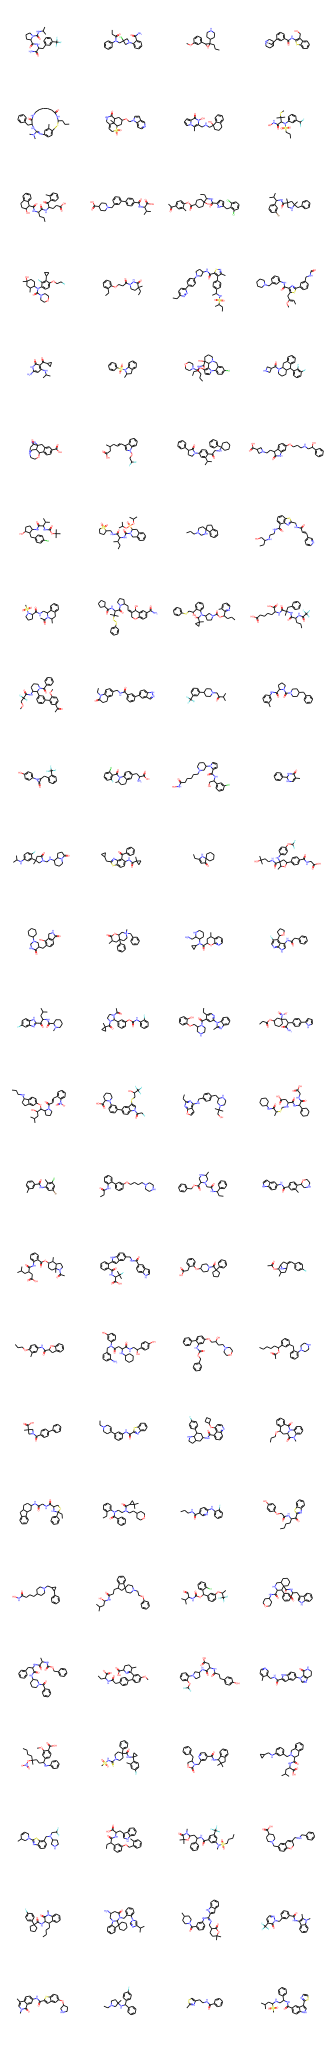

In [7]:
#random.shuffle(molecules)
Draw.MolsToGridImage(molecules[:len(molecules)], molsPerRow=4, maxMols = 100)